In [1]:
%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from matplotlib import pyplot as plt
from matplotlib import cm,colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy as sp
from scipy.spatial import cKDTree
import pickle
from donutlib.decamutil import decaminfo
from scriptUtil import decodeNumberList

from pixmappy import DESMaps, Gnomonic, GalSimWCS
from meshutil import mkDonutAnaDF

Welcome to JupyROOT 6.20/04


In [2]:
%env CAL_PATH=/u/ec/roodman/kipacdisk/Pixmappy/Y6A1_ASTROMETRY

env: CAL_PATH=/u/ec/roodman/kipacdisk/Pixmappy/Y6A1_ASTROMETRY


In [3]:
# read in Shape Mode i-band residuals
from astropy.io import fits
hdu  = fits.open('/u/ec/roodman/Astrophysics/Piff/shape_mode_meanify.fits')


In [4]:
meanify = hdu[1].data
print(meanify.columns)
upiff = meanify['COORDS0'][0][:,0]
vpiff = meanify['COORDS0'][0][:,1]
atmo_size = meanify['PARAMS0'][0][:,0]
atmo_g1 = meanify['PARAMS0'][0][:,1]
atmo_g2 = meanify['PARAMS0'][0][:,2]
print(upiff.shape,vpiff.shape,atmo_size.shape)

ColDefs(
    name = 'COORDS0'; format = '85030D'; dim = '(2,42515)'
    name = 'PARAMS0'; format = '1743115D'; dim = '(41,42515)'
)
(42515,) (42515,) (42515,)


<IPython.core.display.Javascript object>


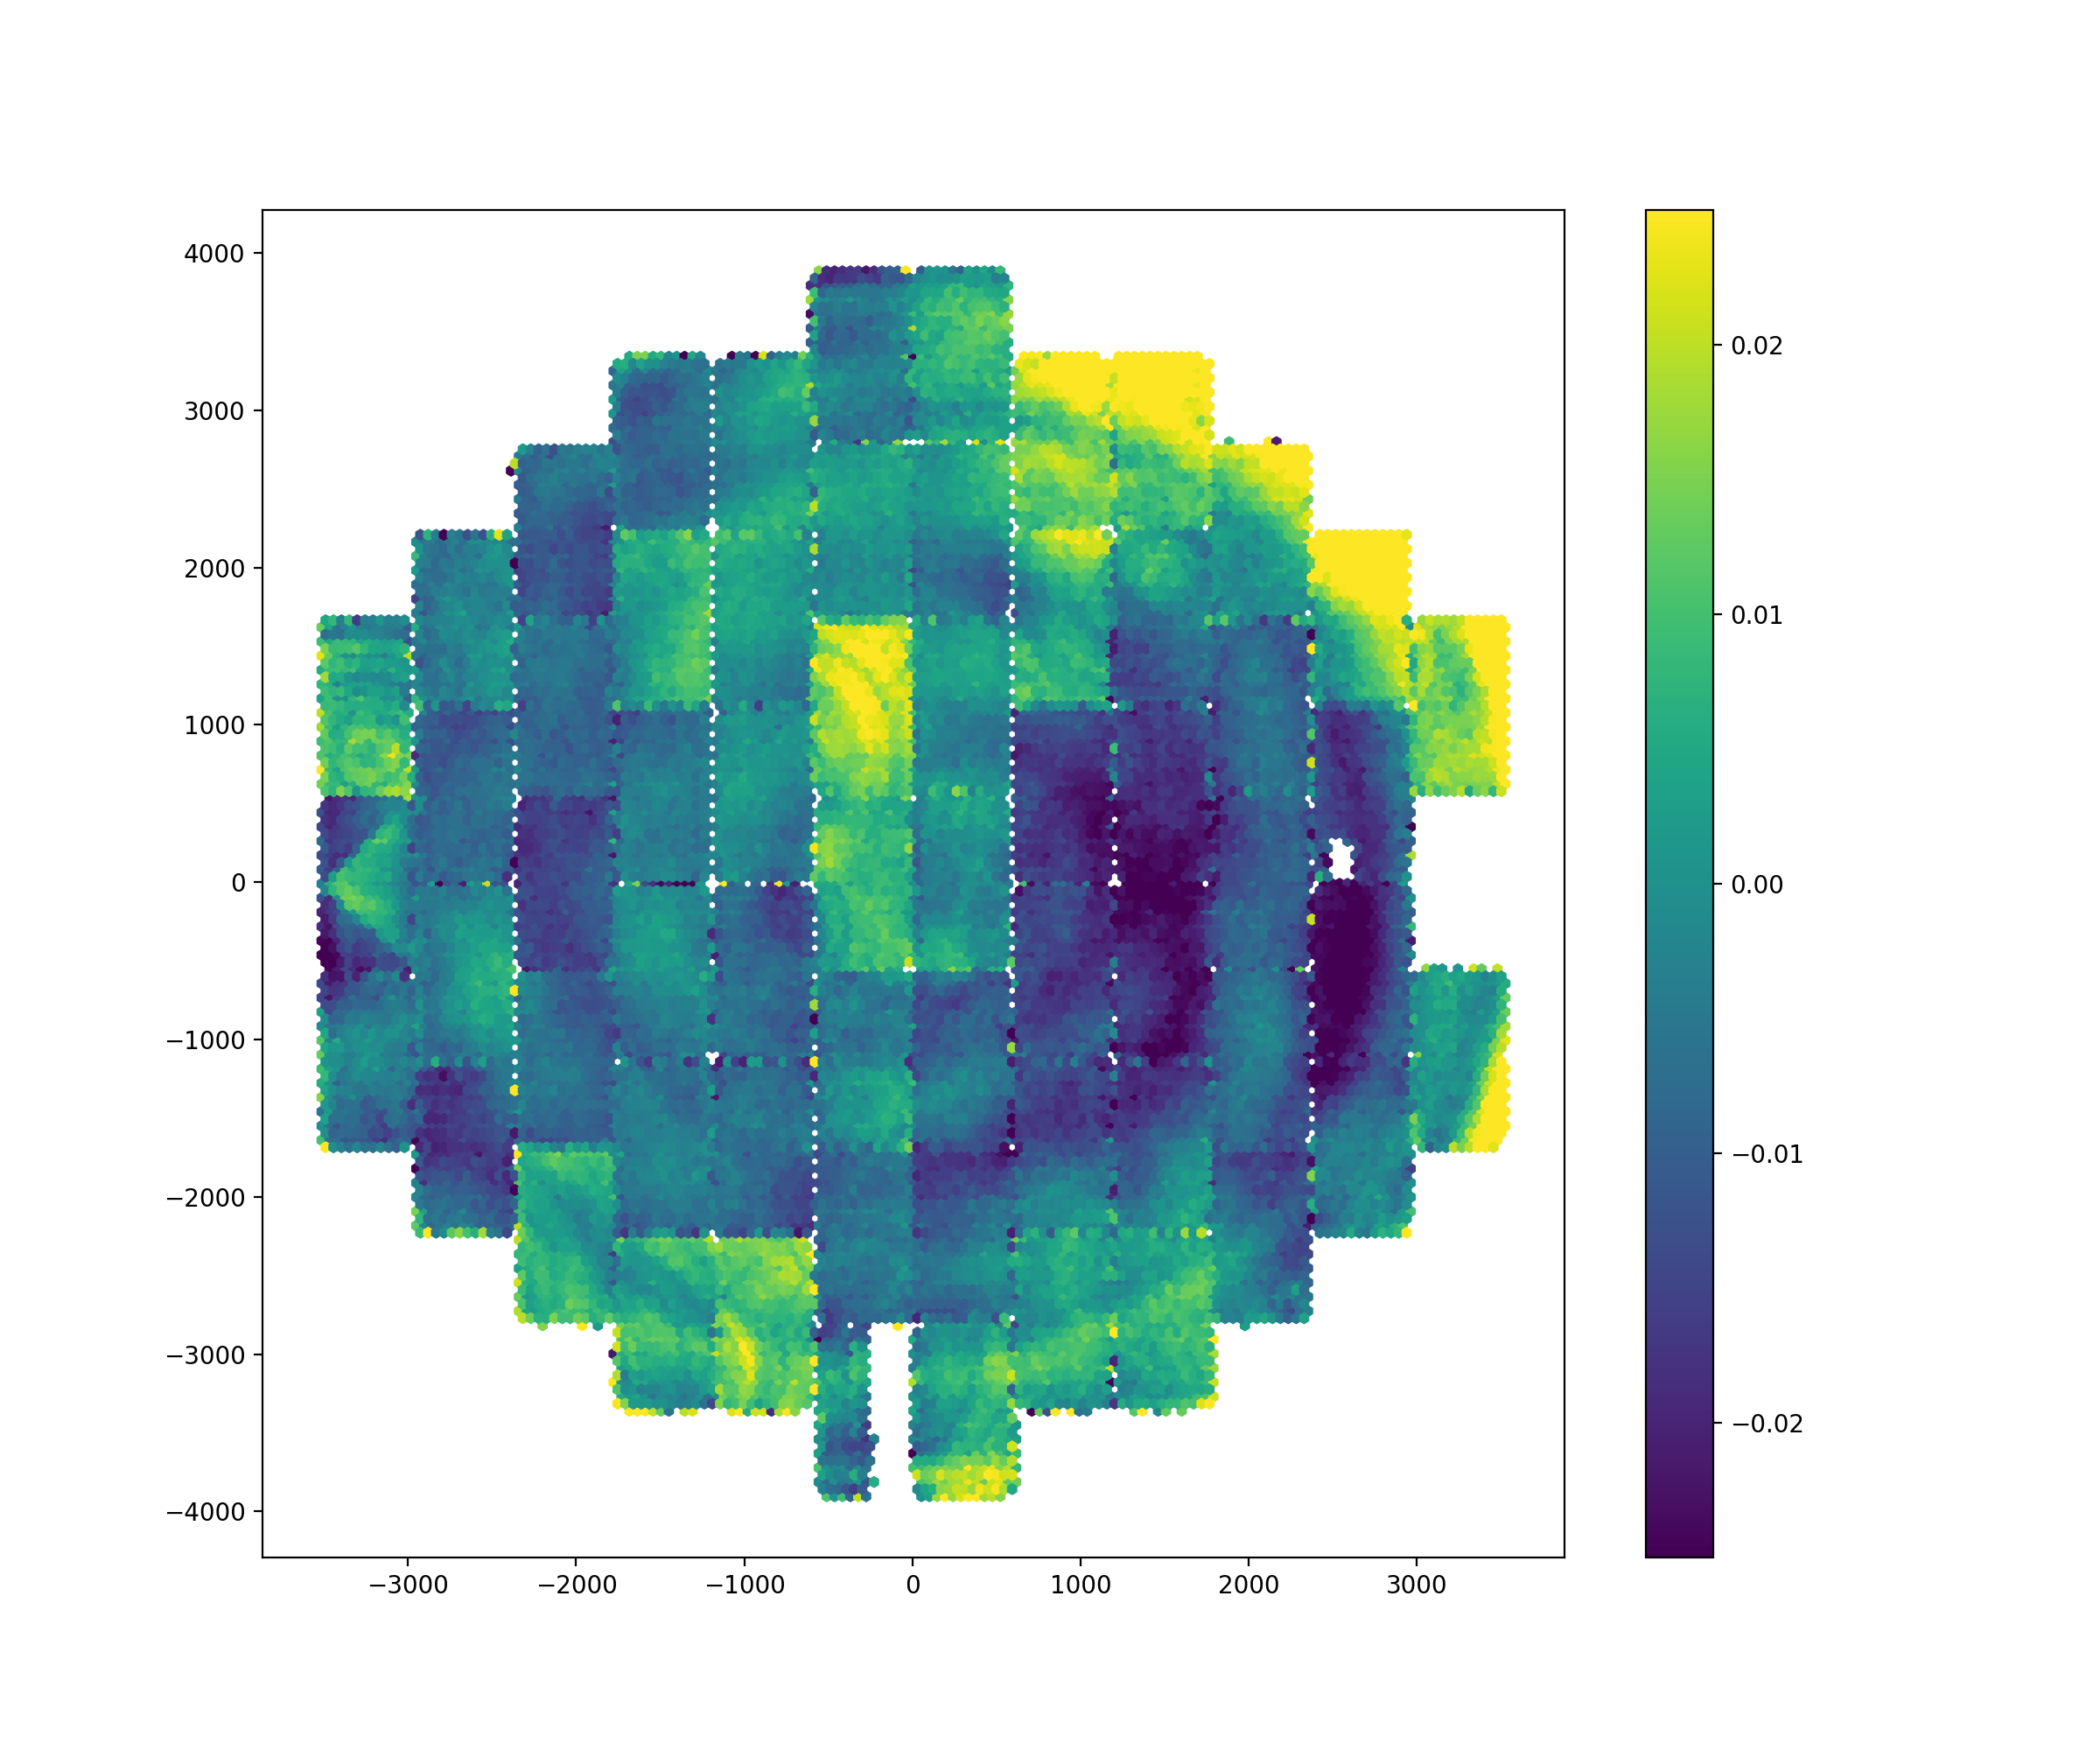

In [5]:
f,ax = plt.subplots(1,1,figsize=(12,10))
h = ax.hexbin(-vpiff,upiff,atmo_size,gridsize=150,vmin=-0.025,vmax=0.025)
f.colorbar(h,ax=ax)

<IPython.core.display.Javascript object>


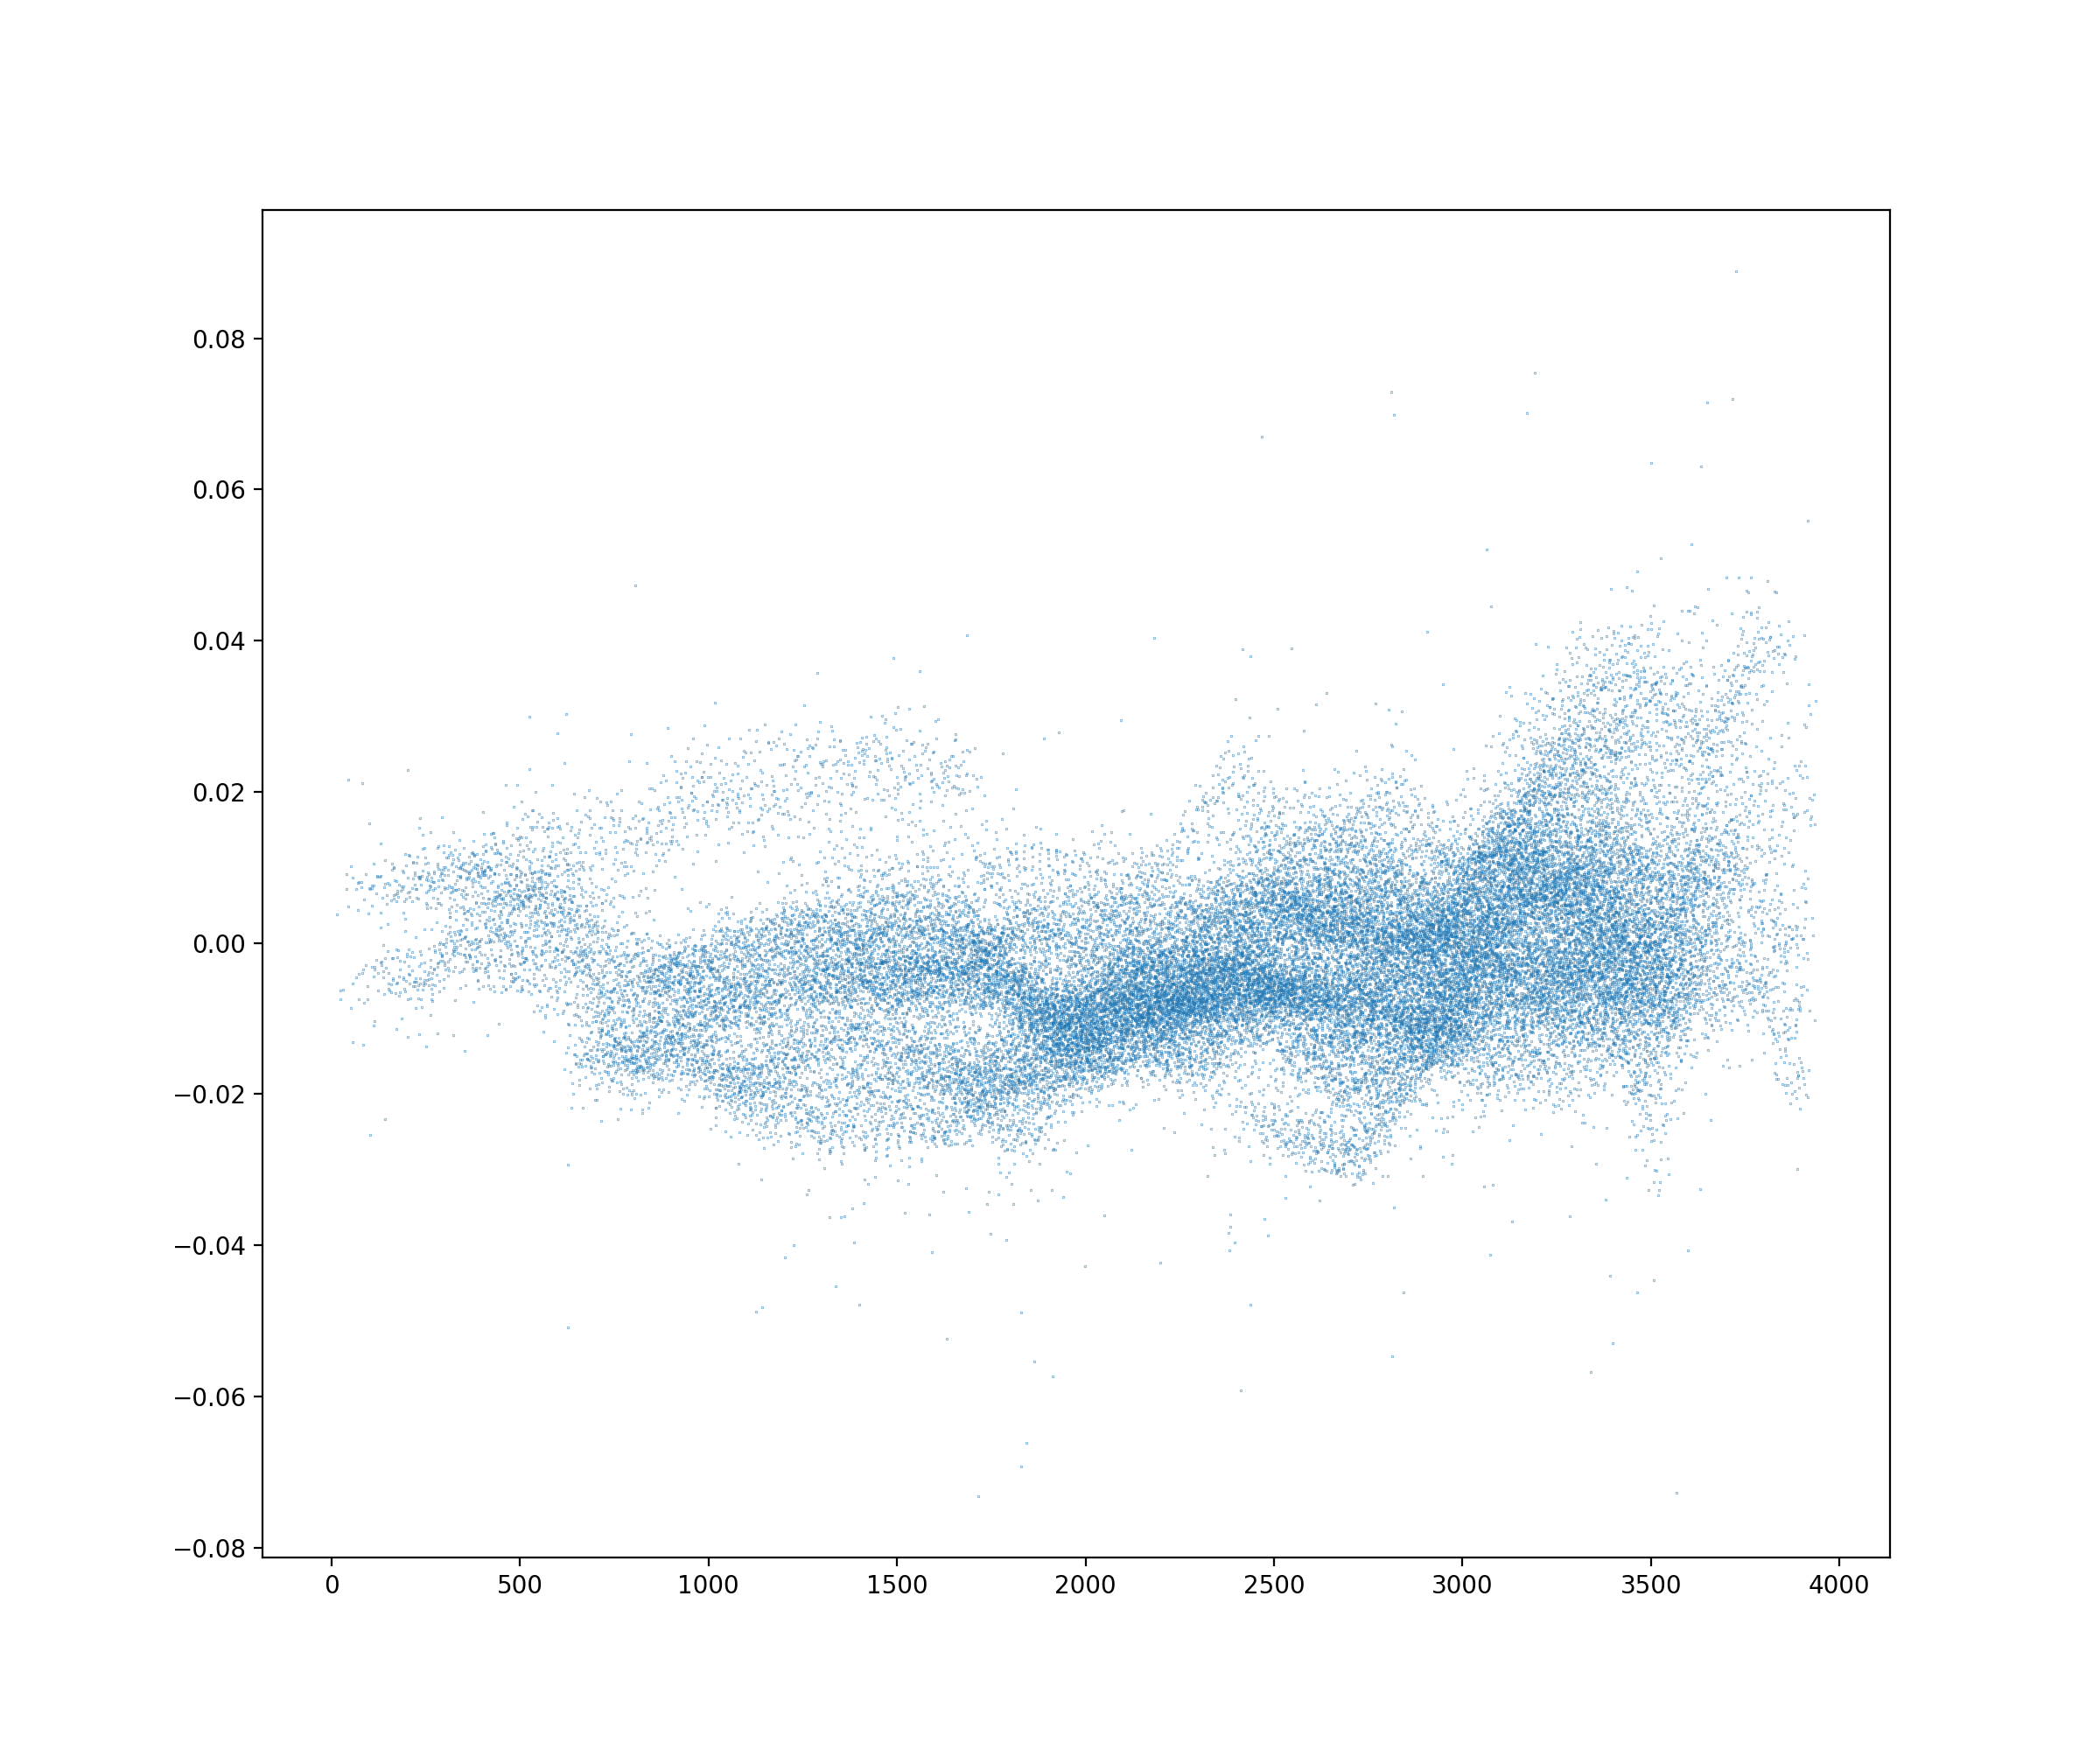

In [6]:
f,ax = plt.subplots(1,1,figsize=(12,10))
s = ax.scatter(np.sqrt(vpiff*vpiff+upiff*upiff),atmo_size,marker='.',s=0.1)


<IPython.core.display.Javascript object>


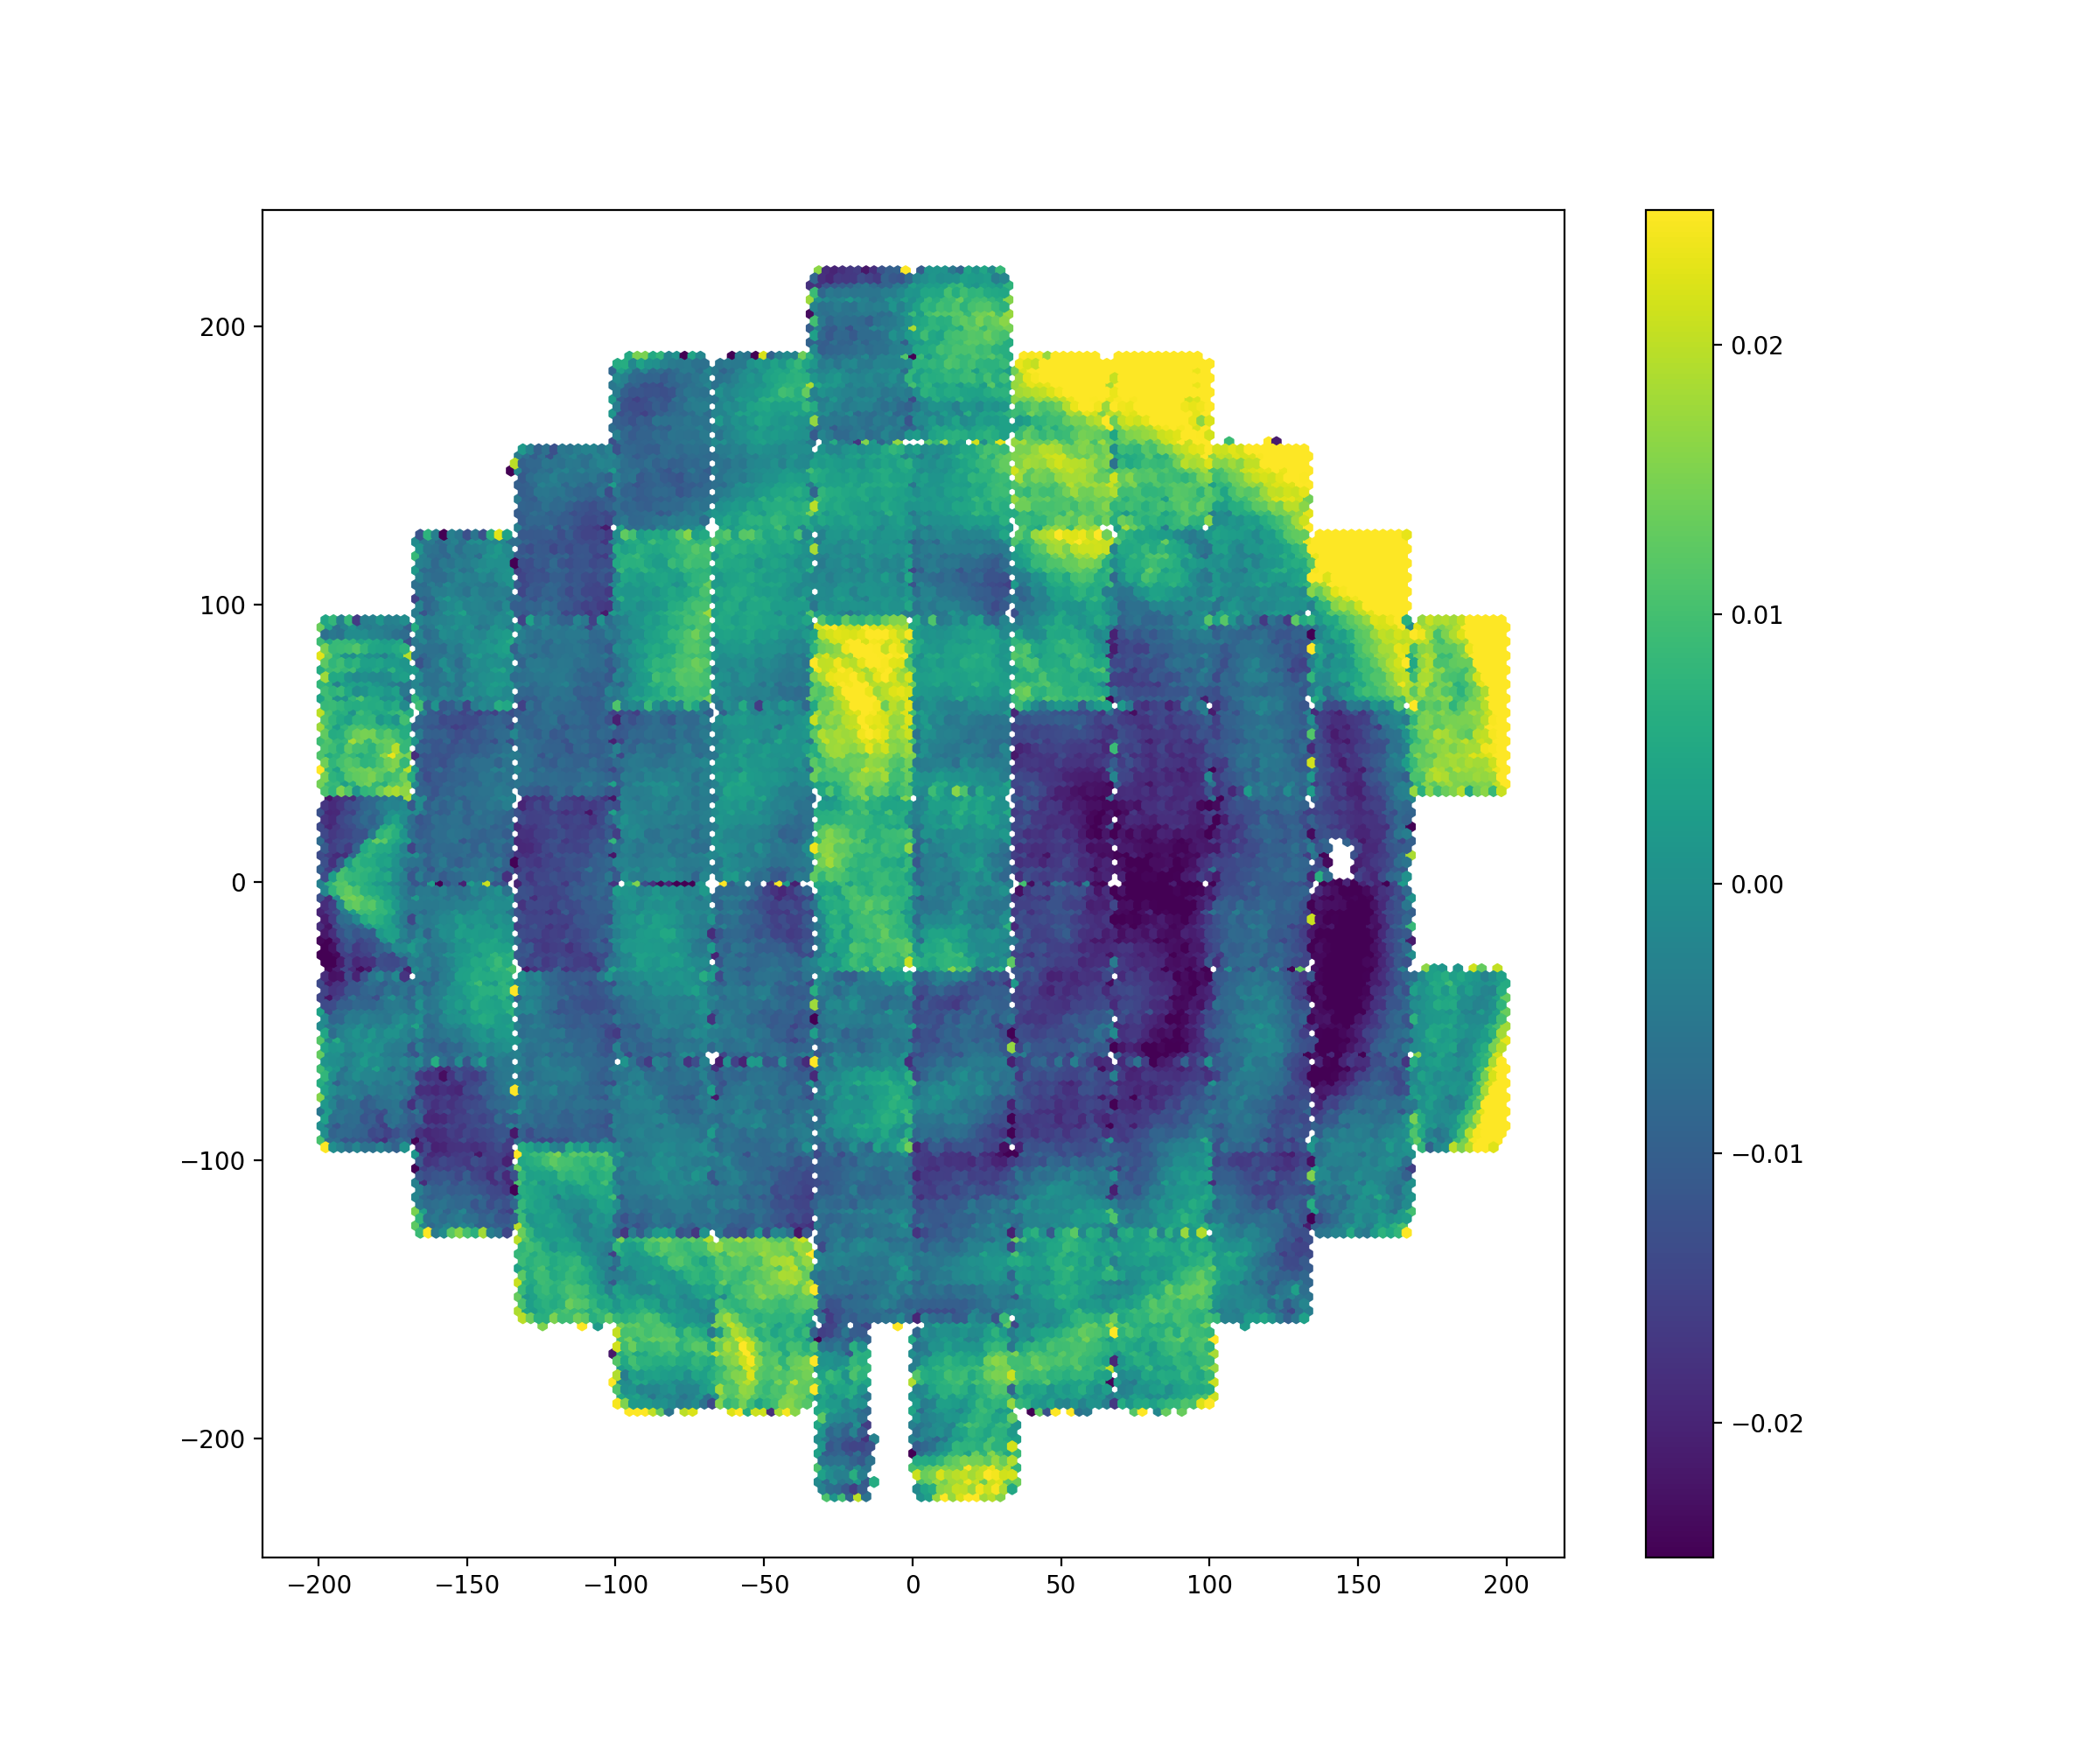

In [7]:
mmperarcsec = 0.015/0.265
f,ax = plt.subplots(1,1,figsize=(12,10))
h = ax.hexbin(-vpiff*mmperarcsec,upiff*mmperarcsec,atmo_size,gridsize=150,vmin=-0.025,vmax=0.025)
f.colorbar(h,ax=ax)

In [9]:
# get Meshes and a DonutAna object - but set nInterpGrid to 128 (usually just 32)
dfDirectory = "/u/ec/roodman/Astrophysics/Donuts/ComboMeshesZemaxIteration2v22"
dfName = "ComboMesh_Science-20140212s2-v22i2_All"
zVarPattern="z%dcorr"
usedFlag=True
minDict={4:-20.,5:-0.2,6:-0.2,7:-0.125,8:-0.125,9:-0.3,10:-0.3,11:-0.15,14:-0.1,15:-0.1}
maxDict={4:20.,5:0.2,6:0.2,7:0.125,8:0.125,9:0.3,10:0.3,11:0.15,14:0.1,15:0.1}

iZs = [4]
da = mkDonutAnaDF(dfDirectory+"/"+dfName+".pkl",iZs,zVarPattern=zVarPattern,sensorSet="ScienceOnly",method="idw",methodVal=(250,1.0),nInterpGrid=128,donutCutString="flagFinal==True")
        
for iZ in iZs:
    print(iZ)
    meshN = "z%dMesh" % (iZ)
    if meshN in da.meshDict:
        aMesh = da.meshDict[meshN]
        X_all,Y_all,Xcen_all,Ycen_all,Z_all,ZVig_all = aMesh.calcMeshMPL2D()



4


In [10]:
print(da.meshDict['z4Mesh'].coordList)

['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31']
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

In [11]:
print(Xcen_all['S4'].shape)

(256, 128)


Exception in thread IPythonHistorySavingThread:
Traceback (most recent call last):
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 834, in run
  File "<decorator-gen-16>", line 2, in writeout_cache
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 58, in needs_sqlite
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 780, in writeout_cache
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/IPython/core/history.py", line 764, in _writeout_input_cache
sqlite3.OperationalError: unable to open database file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/nfs/slac/g/ki/ki06/roodman/Software/anaconda3/lib/python3.7/site-packages/ipykernel/iostream.py", line 97, in _event_pipe
AttributeError: '_thread._loca

In [11]:
expnum=228724

# get average atmo_size by sensor, and compare against diffusion values
# Read solution set from default files.
    
maps = DESMaps()

decamInfo = decaminfo()

iZactual = 4
meshN = "z%dMesh" % (iZactual)
if meshN in da.meshDict:
    aMesh = da.meshDict[meshN]
    X_all,Y_all,Xcen_all,Ycen_all,Z_all,ZVig_all = aMesh.calcMeshMPL2D()

# Acquire the WCS for desired exposure, CCD combination
# ValueError will be raised if there is no astrometric solution for this combination.
PixelSize_all = {}

coordList = X_all.keys()
coordList = ['N4']
    
for ccdnum in coordList:
    print(ccdnum)
    # get wcs for this Sensor
    
    wcs = maps.getDESWCS(expnum, ccdnum)
        
    # loop over points, get pixel coord. and then ra,dec
    Xf_all = Xcen_all[ccdnum].flatten()
    Yf_all = Ycen_all[ccdnum].flatten()
        
    sizef_all = np.zeros(Xf_all.shape)
        
    ix_all,iy_all = decamInfo.getPixel(ccdnum,Xf_all,Yf_all)  
        
    # Map pixel coordinates to RA, Dec, specifying object color
    c = 1.4
    ra,dec = wcs.toSky(ix_all,iy_all,c)

    # Now we're going to ask the WCS to reproject coordinates
    # into a gnomonic projection about a new point, in units of degrees

    for i in range(ra.shape[0]):
        wcs.reprojectTo( Gnomonic(ra[i],dec[i]) )
        size = np.sqrt(np.abs(np.linalg.det(wcs.jacobian(ix_all[i],iy_all[i],c)))*(3600.*3600.))
        sizef_all[i] = size
        
    PixelSize_all[ccdnum] = sizef_all.reshape(Xcen_all[ccdnum].shape)




        
        
    
   
        

 

N4


<IPython.core.display.Javascript object>


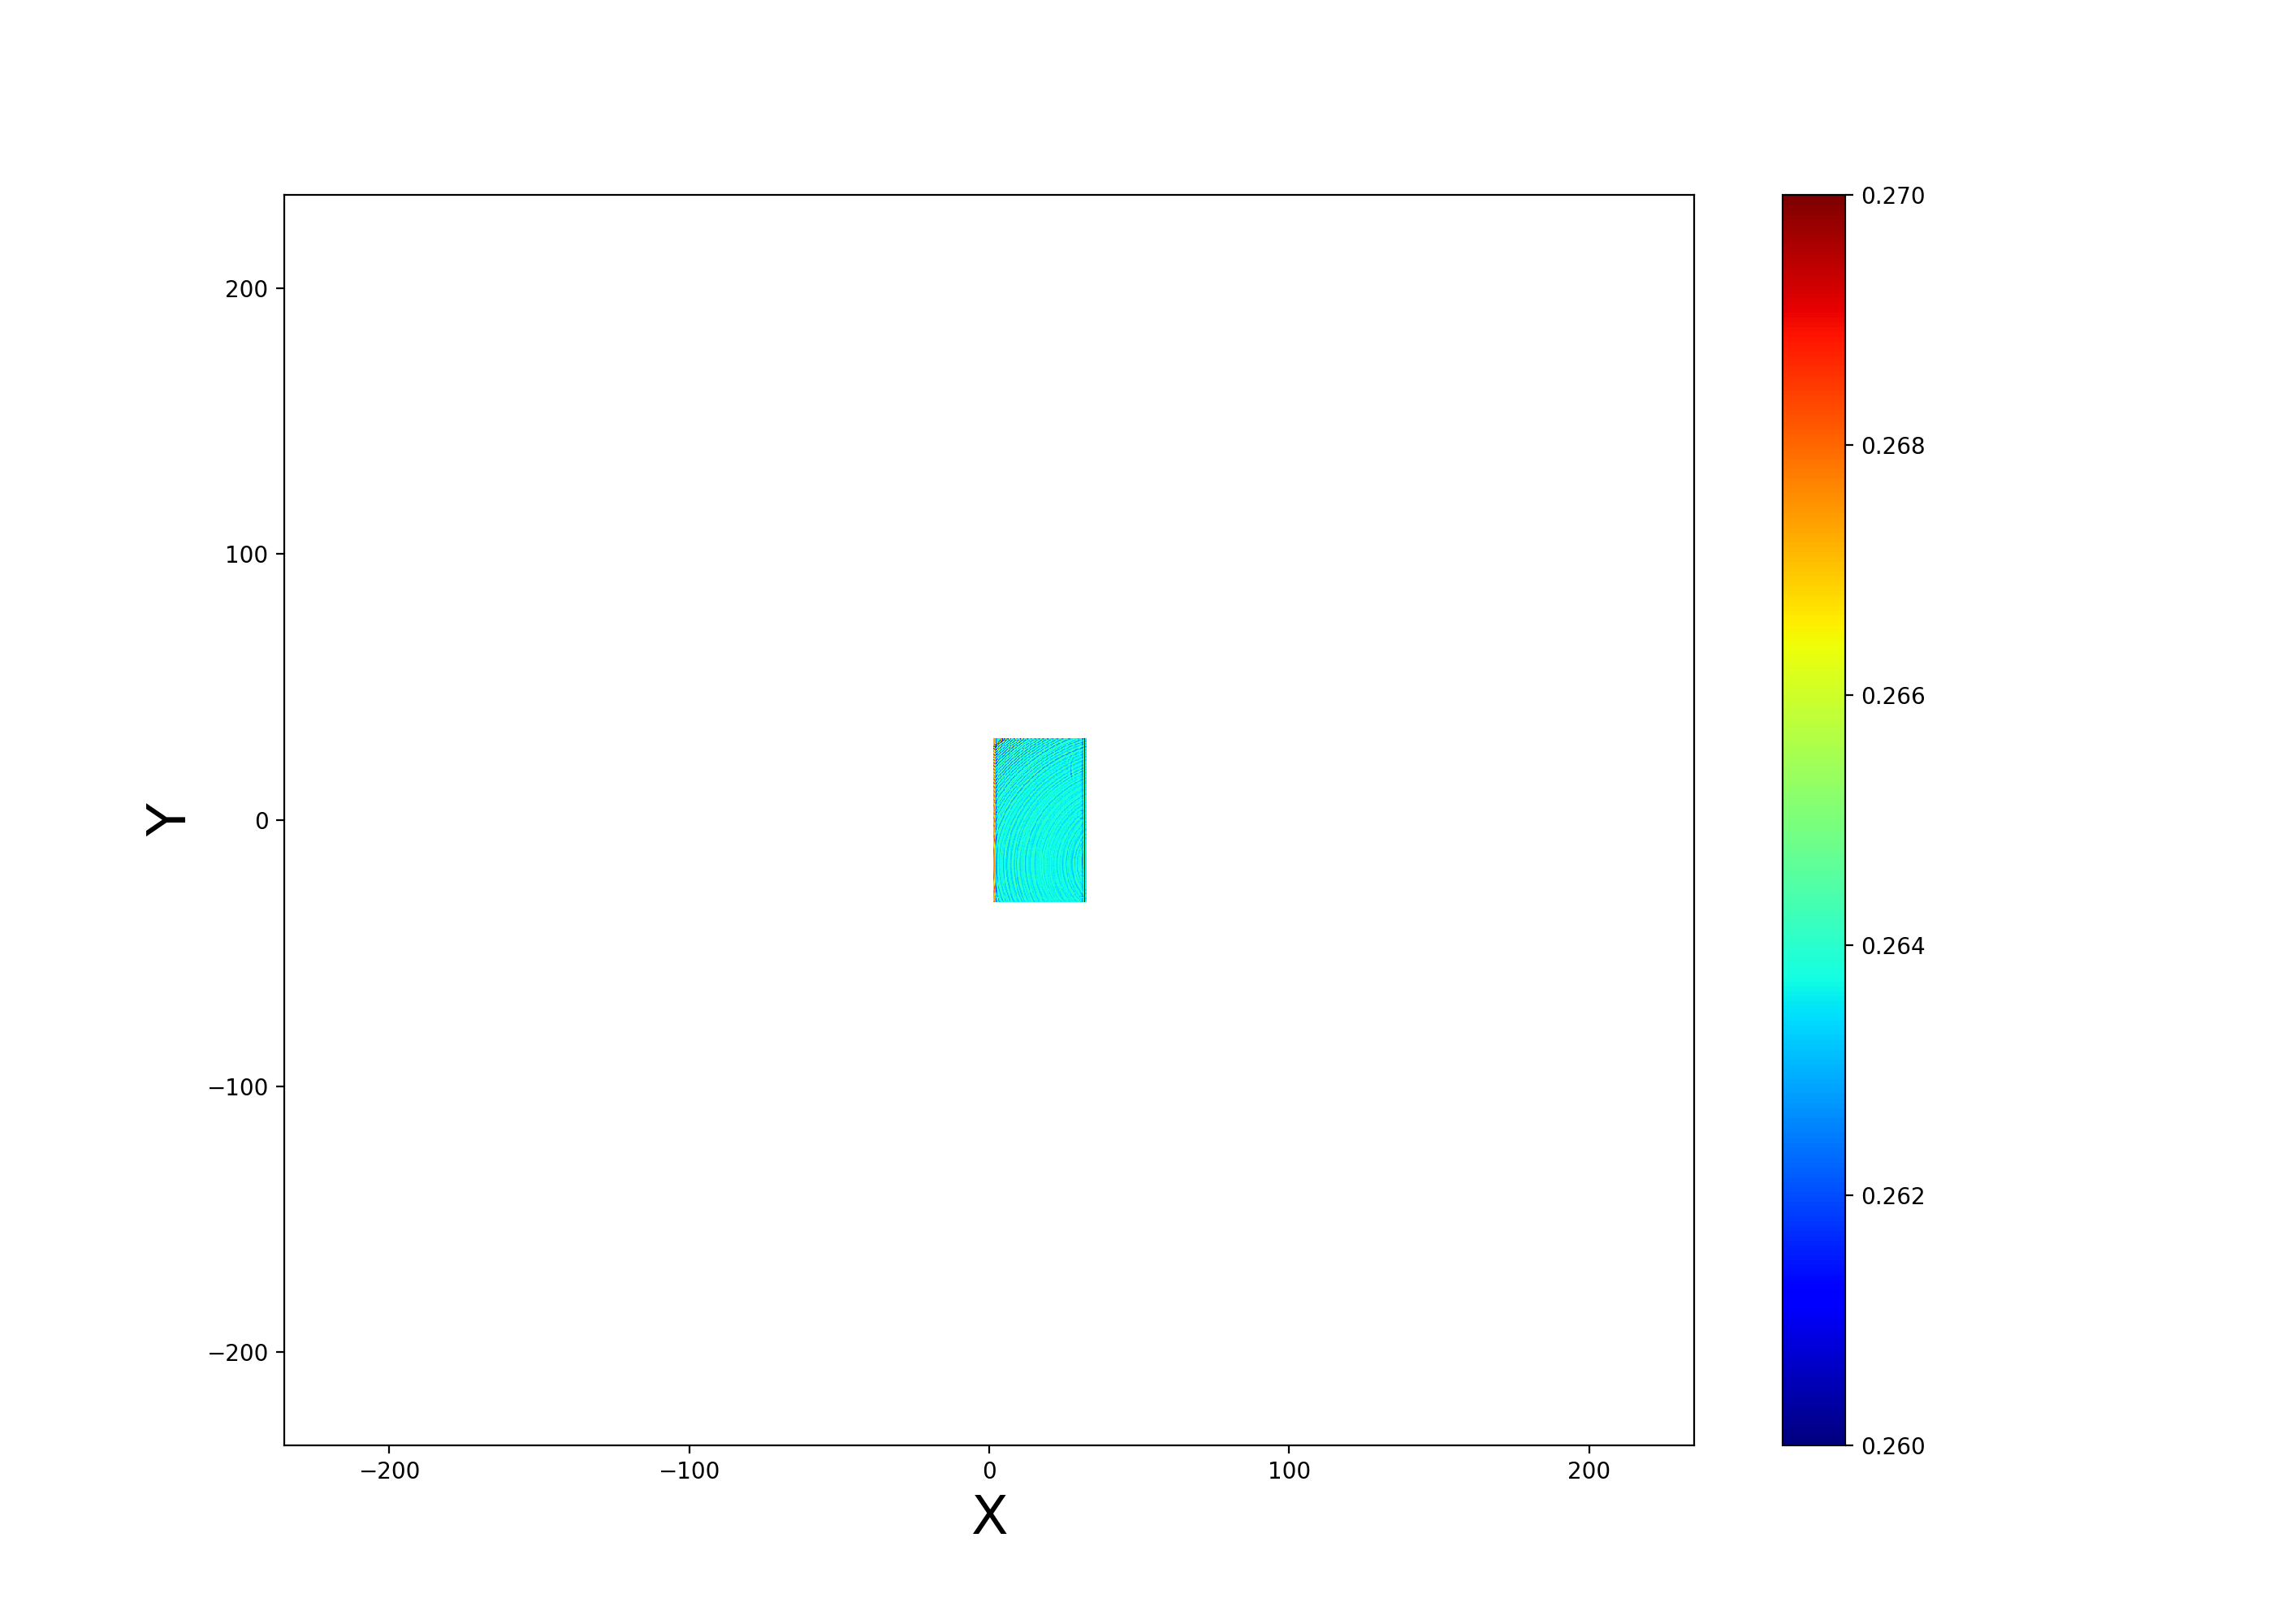

In [12]:
# plots
zmin = 0.26
zmax = 0.27
anorm = colors.Normalize(zmin,zmax,True)
cmap=cm.jet
f,ax = plt.subplots(1,1,figsize=(14,10))
    
# hard code X,Y limits to be DECam boundaries
minX = -235.
maxX = 235.
minY = -235.
maxY = 235.

for iCoord in PixelSize_all.keys():
    cset = ax.pcolormesh(X_all[iCoord], Y_all[iCoord], PixelSize_all[iCoord], cmap=cmap, norm=anorm)
    
ax.set_xlabel('X',fontsize=24)
ax.set_xlim(minX, maxX)
ax.set_ylabel('Y',fontsize=24)
ax.set_ylim(minY, maxY)

# add the colorbar
f.colorbar(cset,ax=ax)

In [13]:
expnum=228724

# get average atmo_size by sensor, and compare against diffusion values
# Read solution set from default files.
    
maps = DESMaps()

decamInfo = decaminfo()

iZactual = 4
meshN = "z%dMesh" % (iZactual)
if meshN in da.meshDict:
    aMesh = da.meshDict[meshN]
    X_all,Y_all,Xcen_all,Ycen_all,Z_all,ZVig_all = aMesh.calcMeshMPL2D()

# Acquire the WCS for desired exposure, CCD combination
# ValueError will be raised if there is no astrometric solution for this combination.
PixelSize2_all = {}
    
coordList = X_all.keys()
    
for ccdnum in coordList:
    print(ccdnum,)
    # get wcs for this Sensor
    try:
        wcs = maps.getDESWCS(expnum, ccdnum)
        
        # loop over points, get pixel coord. and then ra,dec
        Xf_all = Xcen_all[ccdnum].flatten()
        Yf_all = Ycen_all[ccdnum].flatten()
                
        ix_all,iy_all = decamInfo.getPixel(ccdnum,Xf_all,Yf_all)  
        
        # Map pixel coordinates to Jacobian specifying object color
        c = 1.4
        sizes_all = np.sqrt(np.abs(np.linalg.det(wcs.jacobian(ix_all,iy_all,c)))*(3600.*3600.))
        
        PixelSize2_all[ccdnum] = sizes_all.reshape(Xcen_all[ccdnum].shape)
        
    except:
        PixelSize2_all[ccdnum] = None



        
        
    

S1
S2
S3
S4
S5
S6
S7
S8
S9
S10
S11
S12
S13
S14
S15
S16
S17
S18
S19
S20
S21
S22
S23
S24
S25
S26
S27
S28
S29
S30
S31
N1
N2
N3
N4
N5
N6
N7
N8
N9
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N20
N21
N22
N23
N24
N25
N26
N27
N28
N29
N30
N31


In [14]:
print(PixelSize2_all['N4'].flatten().mean())

0.2637207744706713


<IPython.core.display.Javascript object>


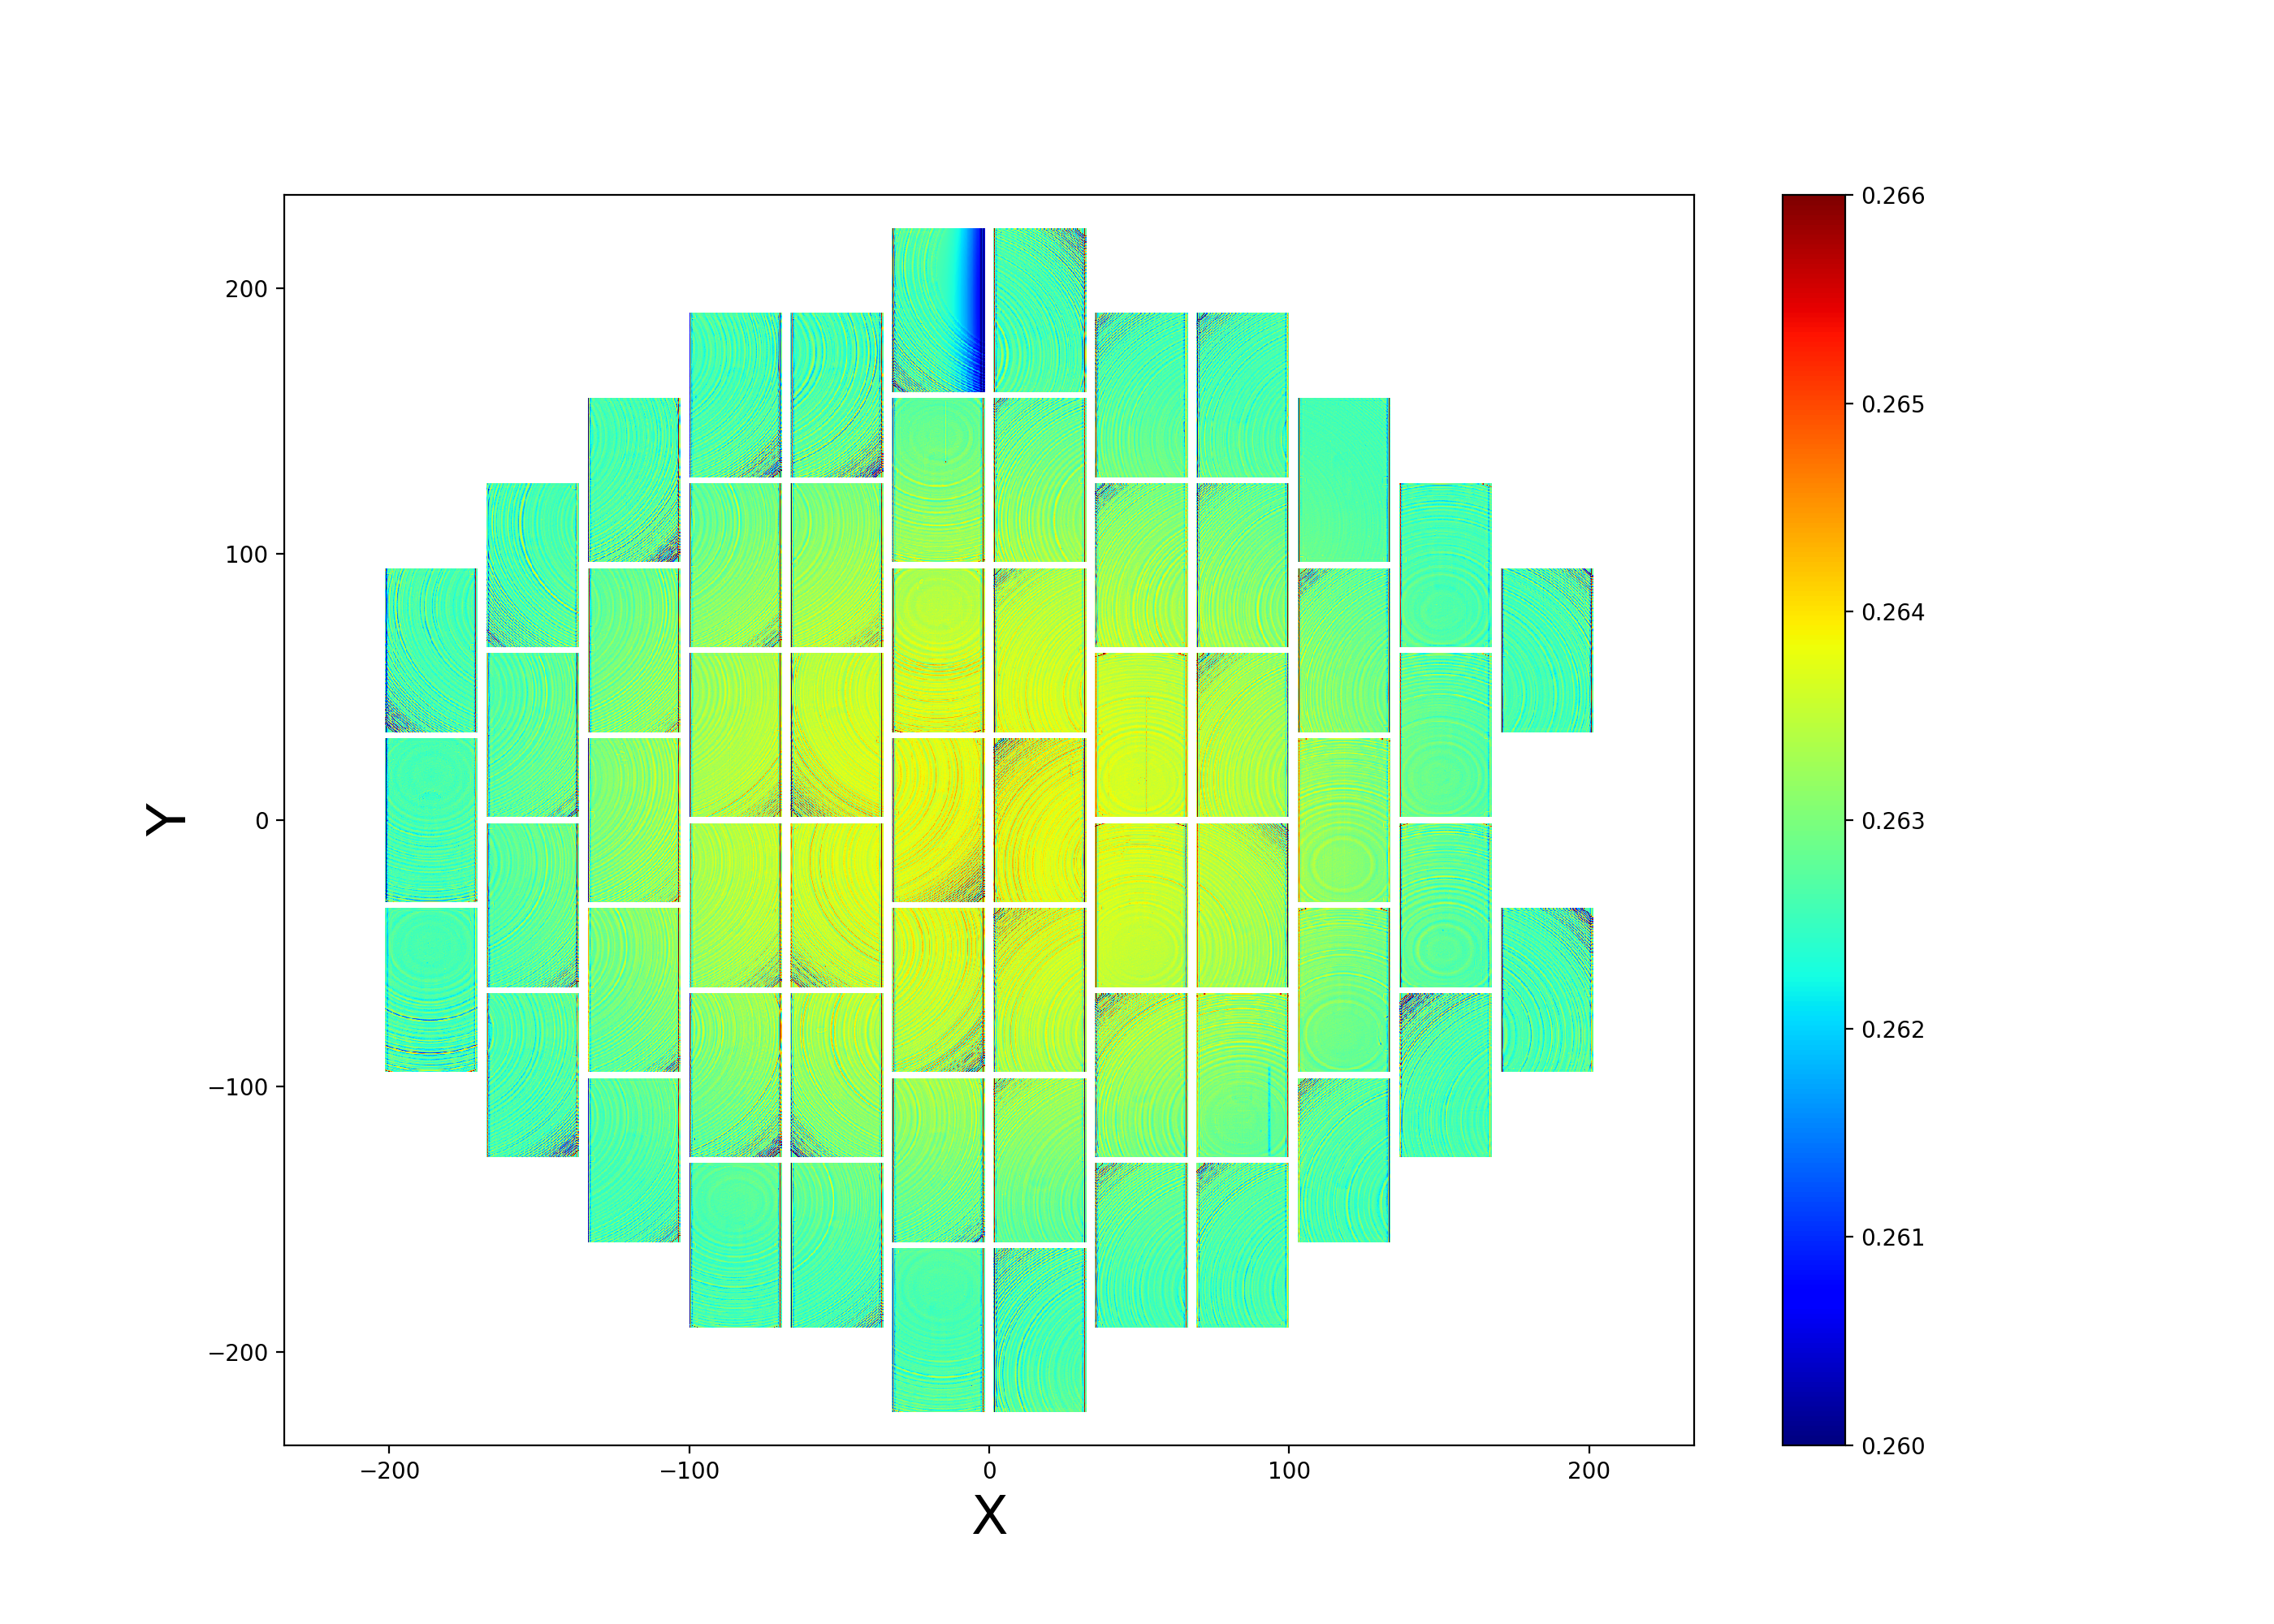

In [15]:
# plots
zmin = 0.26
zmax = 0.266
anorm = colors.Normalize(zmin,zmax,True)
cmap=cm.jet
f,ax = plt.subplots(1,1,figsize=(14,10))
    
# hard code X,Y limits to be DECam boundaries
minX = -235.
maxX = 235.
minY = -235.
maxY = 235.

# plot
for iCoord in PixelSize2_all.keys():
    if PixelSize2_all[iCoord] is not None: 
        
        cset = ax.pcolormesh(X_all[iCoord], Y_all[iCoord], PixelSize2_all[iCoord], cmap=cmap,norm=anorm)
    
ax.set_xlabel('X',fontsize=24)
ax.set_xlim(minX, maxX)
ax.set_ylabel('Y',fontsize=24)
ax.set_ylim(minY, maxY)

# add the colorbar
f.colorbar(cset,ax=ax)

In [ ]:
expnum=228724

decamInfo = decaminfo()

iZactual = 4
meshN = "z%dMesh" % (iZactual)
if meshN in da.meshDict:
    aMesh = da.meshDict[meshN]
    X_all,Y_all,Xcen_all,Ycen_all,Z_all,ZVig_all = aMesh.calcMeshMPL2D()

# Acquire the WCS for desired exposure, CCD combination
# ValueError will be raised if there is no astrometric solution for this combination.
PixelSize3_all = {}
    
coordList = X_all.keys()
coordList = ['N4']
    
for ccdnum in coordList:
    print(ccdnum,)
    # get wcs for this Sensor
    try:
        
        wcs = GalSimWCS(yaml_file='/nfs/slac/g/ki/ki19/des/cpd/y3_piff/astro/zone176.astro',wcs_name='D%d/%s' % (expnum,ccdnum))  #ccdnum here is really ccdname...
                
        # loop over points, get pixel coord. and then ra,dec
        Xf_all = Xcen_all[ccdnum].flatten()
        Yf_all = Ycen_all[ccdnum].flatten()
                
        ix_all,iy_all = decamInfo.getPixel(ccdnum,Xf_all,Yf_all)  
        
        pix_area = wcs.pixelArea(image_pos=galsim.PositionD(ix_all,iy_all), color=1.4)
        
        PixelSize3_all[ccdnum] = pix_area.reshape(Xcen_all[ccdnum].shape)
        
    except:
        print("Problem with ",ccdnum)
        PixelSize3_all[ccdnum] = None





In [16]:
%debug
ccdnum = 'N4'
wcs = GalSimWCS(dir='/nfs/slac/g/ki/ki19/des/cpd/y3_piff/astro/',yaml_file='zone176.astro',wcs_name='D%d/%s' % (expnum,ccdnum))

ERROR:root:No traceback has been produced, nothing to debug.


In [19]:
import galsim
pix_area = wcs.pixelArea(image_pos=galsim.PositionD(100,100), color=1.4)

In [22]:
print(np.sqrt(pix_area))

0.2632365915568455


In [ ]:
# submit jobs to make PixelSize3
ccdname = 'S4'
command = "bsub -R rhel60 -C 0 -q short -o %s.log ./calcPixelSize.py -c %s -o %s.pkl" % (ccdname,ccdname,ccdname)
import os
os.system(command)